# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [1]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

c:\Users\Alex MGG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Device: cuda


In [2]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [3]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


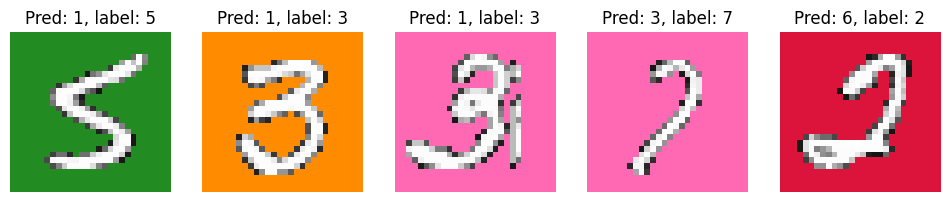

In [4]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

---
### Any code you want to add, put it below this markdown cell

## **Solution**

After trying different approaches, we saw that the model was returning zero gradients, so any explanation method that used gradients was not useful. Also, we noticed that the images had background color, and saw that by removing it, the model predicted completely different labels. This made us think that the model was barely focusing on the digit itself, and more on the image as a whole.

With this two things in mind, we decided to create a new method in which we calculated an updating tensor as if it was a gradient, but we used different inputs to calculate it. To do this, we created two noise tensors that would allow us create two noisy images that we would compare in order to calculate the updating tensor. If one of the images performed better than the other, we knew that the image should be updated in the direction of the noise that created the better performing image. Added to this, since we had to keep more than 60% of the original pixels, we created a mask that only allowed us to change a small square around the digit, keeping the rest of the image unchanged.

After asking ChatGPT about the validity of this method, it told us that it is actually called "Two-point gradient estimation", and that it is a valid method to estimate gradients when they are not available.

Therefore, by changing 37.5% of the pixels, we obtained the results below.

#### **Two-point gradient estimator**

Changing 37.5% of pixels


  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 188.66it/s]

After 1 steps: Pred: 1, Label: 5, Loss: -1.3313758373260498
After 11 steps: Pred: 3, Label: 5, Loss: -1.0800108909606934
After 21 steps: Pred: 5, Label: 5, Loss: -0.7757163047790527
Converged at epoch 21


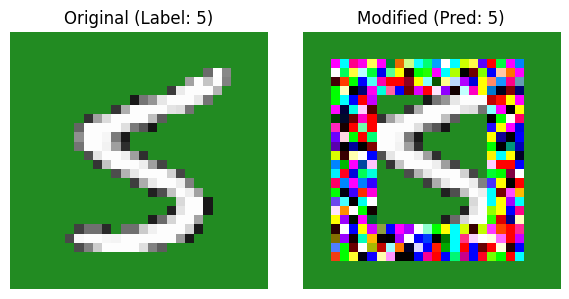

In [220]:
# IDX 0

from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(0)

idx = 0
epochs = 100
lr = 10
sigma = 1

image = to_tensor(Image.open(image_files[idx])).unsqueeze(0).to(device)
label = int(image_files[idx].stem[-1])

mask1 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask1[:, 7:21, 8:20] = 1.0    # Center square
mask2 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask2[:, 3:25, 3:24] = 1.0   # Surrounding area

mask = mask2 - mask1  # [C, H, W]
print(f"Changing {(mask).sum() / mask.numel() * 100}% of pixels")

# Visualize mask
# plt.imshow(mask.mean(dim=0).squeeze().cpu(), cmap="gray")
# plt.title("Mask of modified pixels")
# plt.axis("off")
# plt.show()


# Create noisy images
with torch.no_grad():
    new_img = None
    for epoch in tqdm(range(epochs)):
        eps1 = torch.randn_like(image, requires_grad=True).to(device)
        eps1 = eps1 * mask.unsqueeze(0)
        eps2 = torch.randn_like(image, requires_grad=True).to(device)
        eps2 = eps2 * mask.unsqueeze(0)
        noisy_image1 = (image + sigma * eps1).clamp(0, 1)
        noisy_image2 = (image + sigma * eps2).clamp(0, 1)

        f1 = model(noisy_image1)[:, label]
        f2 = model(noisy_image2)[:, label]
        # print("f1:", f1)
        # print("f2:", f2)

        grad_estimate = (eps1 - eps2) * (f1 - f2) / (2 * sigma)
        image = (image + lr * grad_estimate).clamp(0, 1)

        output = model(image)
        loss = -output[0, label]
        pred = output.argmax(dim=1).item()
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"After {epoch + 1} steps: Pred: {pred}, Label: {label}, Loss: {loss.item()}")
        if pred == label:
            new_img = image.detach()
            print(f"Converged at epoch {epoch + 1}")
            break
    
    if new_img is None:
        new_img = image.detach()

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(to_pil(to_tensor(Image.open(image_files[idx])).squeeze().cpu()))
ax[0].set_title(f"Original (Label: {label})")
ax[0].axis("off")
ax[1].imshow(to_pil(new_img.squeeze().cpu()))
ax[1].set_title(f"Modified (Pred: {pred})")
ax[1].axis("off")
plt.tight_layout()
plt.show()

# Save image
output_path = f"../data/MNIST/challenge/edited/{image_files[idx].stem}.png"
to_pil(new_img.squeeze().cpu()).save(output_path)

Changing 37.5% of pixels


 48%|████▊     | 48/100 [00:00<00:00, 358.99it/s]

After 1 steps: Pred: 1, Label: 3, Loss: -1.598129153251648
After 11 steps: Pred: 1, Label: 3, Loss: -1.598129153251648
After 21 steps: Pred: 1, Label: 3, Loss: -1.598129153251648
After 31 steps: Pred: 1, Label: 3, Loss: -1.598129153251648
After 41 steps: Pred: 1, Label: 3, Loss: -1.598129153251648
Converged at epoch 49


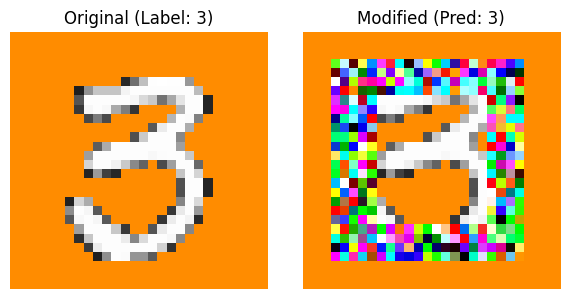

In [221]:
# IDX 1

from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(0)

idx = 1
epochs = 100
lr = 10
sigma = 1

image = to_tensor(Image.open(image_files[idx])).unsqueeze(0).to(device)
label = int(image_files[idx].stem[-1])

mask1 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask1[:, 7:21, 8:20] = 1.0    # Center square
mask2 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask2[:, 3:25, 3:24] = 1.0   # Surrounding area

mask = mask2 - mask1  # [C, H, W]
print(f"Changing {(mask).sum() / mask.numel() * 100}% of pixels")

# Visualize mask
# plt.imshow(mask.mean(dim=0).squeeze().cpu(), cmap="gray")
# plt.title("Mask of modified pixels")
# plt.axis("off")
# plt.show()


# Create noisy images
with torch.no_grad():
    new_img = None
    for epoch in tqdm(range(epochs)):
        eps1 = torch.randn_like(image, requires_grad=True).to(device)
        eps1 = eps1 * mask.unsqueeze(0)
        eps2 = torch.randn_like(image, requires_grad=True).to(device)
        eps2 = eps2 * mask.unsqueeze(0)
        noisy_image1 = (image + sigma * eps1).clamp(0, 1)
        noisy_image2 = (image + sigma * eps2).clamp(0, 1)

        f1 = model(noisy_image1)[:, label]
        f2 = model(noisy_image2)[:, label]
        # print("f1:", f1)
        # print("f2:", f2)

        grad_estimate = (eps1 - eps2) * (f1 - f2) / (2 * sigma)
        image = (image + lr * grad_estimate).clamp(0, 1)

        output = model(image)
        loss = -output[0, label]
        pred = output.argmax(dim=1).item()
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"After {epoch + 1} steps: Pred: {pred}, Label: {label}, Loss: {loss.item()}")
        if pred == label:
            new_img = image.detach()
            print(f"Converged at epoch {epoch + 1}")
            break
    
    if new_img is None:
        new_img = image.detach()

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(to_pil(to_tensor(Image.open(image_files[idx])).squeeze().cpu()))
ax[0].set_title(f"Original (Label: {label})")
ax[0].axis("off")
ax[1].imshow(to_pil(new_img.squeeze().cpu()))
ax[1].set_title(f"Modified (Pred: {pred})")
ax[1].axis("off")
plt.tight_layout()
plt.show()

# Save image
output_path = f"../data/MNIST/challenge/edited/{image_files[idx].stem}.png"
to_pil(new_img.squeeze().cpu()).save(output_path)

Changing 37.5% of pixels


  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 316.40it/s]

After 1 steps: Pred: 5, Label: 3, Loss: 0.4483858346939087
After 11 steps: Pred: 5, Label: 3, Loss: 0.5839866399765015
After 21 steps: Pred: 3, Label: 3, Loss: -1.3728185892105103
Converged at epoch 21


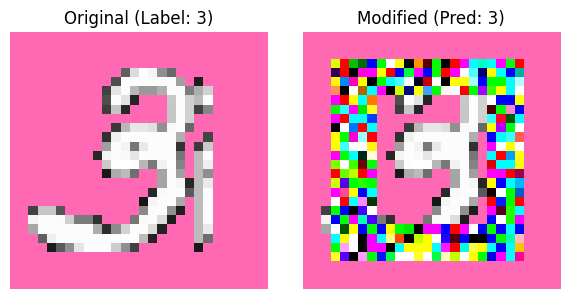

In [222]:
# IDX 2

from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(0)

idx = 2
epochs = 100
lr = 10
sigma = 1

image = to_tensor(Image.open(image_files[idx])).unsqueeze(0).to(device)
label = int(image_files[idx].stem[-1])

mask1 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask1[:, 7:21, 8:20] = 1.0    # Center square
mask2 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask2[:, 3:25, 3:24] = 1.0   # Surrounding area

mask = mask2 - mask1  # [C, H, W]
print(f"Changing {(mask).sum() / mask.numel() * 100}% of pixels")

# Visualize mask
# plt.imshow(mask.mean(dim=0).squeeze().cpu(), cmap="gray")
# plt.title("Mask of modified pixels")
# plt.axis("off")
# plt.show()


# Create noisy images
with torch.no_grad():
    new_img = None
    for epoch in tqdm(range(epochs)):
        eps1 = torch.randn_like(image, requires_grad=True).to(device)
        eps1 = eps1 * mask.unsqueeze(0)
        eps2 = torch.randn_like(image, requires_grad=True).to(device)
        eps2 = eps2 * mask.unsqueeze(0)
        noisy_image1 = (image + sigma * eps1).clamp(0, 1)
        noisy_image2 = (image + sigma * eps2).clamp(0, 1)

        f1 = model(noisy_image1)[:, label]
        f2 = model(noisy_image2)[:, label]
        # print("f1:", f1)
        # print("f2:", f2)

        grad_estimate = (eps1 - eps2) * (f1 - f2) / (2 * sigma)
        image = (image + lr * grad_estimate).clamp(0, 1)

        output = model(image)
        loss = -output[0, label]
        pred = output.argmax(dim=1).item()
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"After {epoch + 1} steps: Pred: {pred}, Label: {label}, Loss: {loss.item()}")
        if pred == label:
            new_img = image.detach()
            print(f"Converged at epoch {epoch + 1}")
            break
    
    if new_img is None:
        new_img = image.detach()

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(to_pil(to_tensor(Image.open(image_files[idx])).squeeze().cpu()))
ax[0].set_title(f"Original (Label: {label})")
ax[0].axis("off")
ax[1].imshow(to_pil(new_img.squeeze().cpu()))
ax[1].set_title(f"Modified (Pred: {pred})")
ax[1].axis("off")
plt.tight_layout()
plt.show()

# Save image
output_path = f"../data/MNIST/challenge/edited/{image_files[idx].stem}.png"
to_pil(new_img.squeeze().cpu()).save(output_path)

Changing 37.5% of pixels


 32%|███▏      | 32/100 [00:00<00:00, 276.35it/s]

After 1 steps: Pred: 6, Label: 7, Loss: 1.9912254810333252
After 11 steps: Pred: 6, Label: 7, Loss: 1.4533967971801758
After 21 steps: Pred: 5, Label: 7, Loss: 0.29956841468811035
After 31 steps: Pred: 6, Label: 7, Loss: 5.467447280883789
Converged at epoch 33


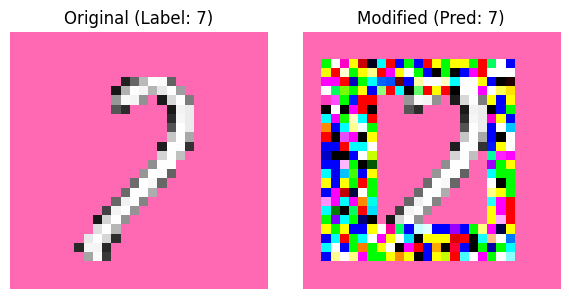

In [223]:
# IDX 3

from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(0)

idx = 3
epochs = 100
lr = 10
sigma = 1

image = to_tensor(Image.open(image_files[idx])).unsqueeze(0).to(device)
label = int(image_files[idx].stem[-1])

mask1 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask1[:, 7:21, 8:20] = 1.0    # Center square
mask2 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask2[:, 3:25, 2:23] = 1.0   # Surrounding area

mask = mask2 - mask1  # [C, H, W]
print(f"Changing {(mask).sum() / mask.numel() * 100}% of pixels")

# Visualize mask
# plt.imshow(mask.mean(dim=0).squeeze().cpu(), cmap="gray")
# plt.title("Mask of modified pixels")
# plt.axis("off")
# plt.show()


# Create noisy images
with torch.no_grad():
    new_img = None
    for epoch in tqdm(range(epochs)):
        eps1 = torch.randn_like(image, requires_grad=True).to(device)
        eps1 = eps1 * mask.unsqueeze(0)
        eps2 = torch.randn_like(image, requires_grad=True).to(device)
        eps2 = eps2 * mask.unsqueeze(0)
        noisy_image1 = (image + sigma * eps1).clamp(0, 1)
        noisy_image2 = (image + sigma * eps2).clamp(0, 1)

        f1 = model(noisy_image1)[:, label]
        f2 = model(noisy_image2)[:, label]
        # print("f1:", f1)
        # print("f2:", f2)

        grad_estimate = (eps1 - eps2) * (f1 - f2) / (2 * sigma)
        image = (image + lr * grad_estimate).clamp(0, 1)

        output = model(image)
        loss = -output[0, label]
        pred = output.argmax(dim=1).item()
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"After {epoch + 1} steps: Pred: {pred}, Label: {label}, Loss: {loss.item()}")
        if pred == label:
            new_img = image.detach()
            print(f"Converged at epoch {epoch + 1}")
            break
    
    if new_img is None:
        new_img = image.detach()

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(to_pil(to_tensor(Image.open(image_files[idx])).squeeze().cpu()))
ax[0].set_title(f"Original (Label: {label})")
ax[0].axis("off")
ax[1].imshow(to_pil(new_img.squeeze().cpu()))
ax[1].set_title(f"Modified (Pred: {pred})")
ax[1].axis("off")
plt.tight_layout()
plt.show()

# Save image
output_path = f"../data/MNIST/challenge/edited/{image_files[idx].stem}.png"
to_pil(new_img.squeeze().cpu()).save(output_path)

Changing 37.5% of pixels


  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 6/100 [00:00<00:00, 408.95it/s]

After 1 steps: Pred: 6, Label: 2, Loss: -6.768916130065918
Converged at epoch 7


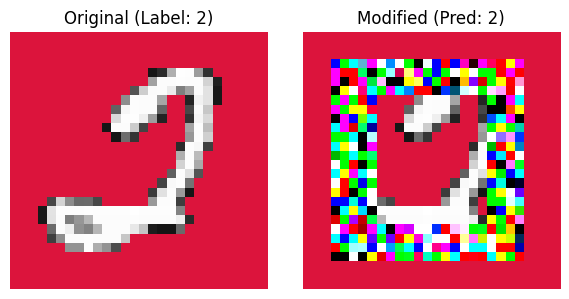

In [224]:
# IDX 4

from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(0)

idx = 4
epochs = 100
lr = 10
sigma = 1

image = to_tensor(Image.open(image_files[idx])).unsqueeze(0).to(device)
label = int(image_files[idx].stem[-1])

mask1 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask1[:, 7:21, 8:20] = 1.0    # Center square
mask2 = torch.zeros_like(image.squeeze(0))  # [C, H, W]
mask2[:, 3:25, 3:24] = 1.0   # Surrounding area

mask = mask2 - mask1  # [C, H, W]
print(f"Changing {(mask).sum() / mask.numel() * 100}% of pixels")

# Visualize mask
# plt.imshow(mask.mean(dim=0).squeeze().cpu(), cmap="gray")
# plt.title("Mask of modified pixels")
# plt.axis("off")
# plt.show()


# Create noisy images
with torch.no_grad():
    new_img = None
    for epoch in tqdm(range(epochs)):
        eps1 = torch.randn_like(image, requires_grad=True).to(device)
        eps1 = eps1 * mask.unsqueeze(0)
        eps2 = torch.randn_like(image, requires_grad=True).to(device)
        eps2 = eps2 * mask.unsqueeze(0)
        noisy_image1 = (image + sigma * eps1).clamp(0, 1)
        noisy_image2 = (image + sigma * eps2).clamp(0, 1)

        f1 = model(noisy_image1)[:, label]
        f2 = model(noisy_image2)[:, label]
        # print("f1:", f1)
        # print("f2:", f2)

        grad_estimate = (eps1 - eps2) * (f1 - f2) / (2 * sigma)
        image = (image + lr * grad_estimate).clamp(0, 1)

        output = model(image)
        loss = -output[0, label]
        pred = output.argmax(dim=1).item()
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"After {epoch + 1} steps: Pred: {pred}, Label: {label}, Loss: {loss.item()}")
        if pred == label:
            new_img = image.detach()
            print(f"Converged at epoch {epoch + 1}")
            break
    
    if new_img is None:
        new_img = image.detach()

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(to_pil(to_tensor(Image.open(image_files[idx])).squeeze().cpu()))
ax[0].set_title(f"Original (Label: {label})")
ax[0].axis("off")
ax[1].imshow(to_pil(new_img.squeeze().cpu()))
ax[1].set_title(f"Modified (Pred: {pred})")
ax[1].axis("off")
plt.tight_layout()
plt.show()

# Save image
output_path = f"../data/MNIST/challenge/edited/{image_files[idx].stem}.png"
to_pil(new_img.squeeze().cpu()).save(output_path)

## Other failed tries

#### Transform images to grayscale

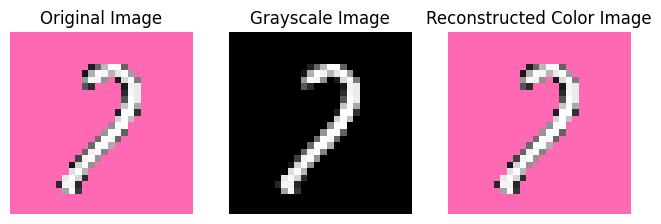

In [117]:
def transform_to_grayscale(img):
    """
    Convert a 3-channel image tensor to grayscale.
    
    Args:
        img (torch.Tensor): Input image tensor of shape [1, C, H, W].

    Returns:
        torch.Tensor: Grayscale image tensor of shape [1, 1, H, W].
        background_color (torch.Tensor): The background color used for conversion.
    """
    # Determine the mask where the number is written (non-background)
    mask = (img[:, 0, :, :] == img[:, 1, :, :]) & (img[:, 1, :, :] == img[:, 2, :, :])

    # Determine the background mask
    background_mask = ~mask # Shape: [1, H, W]
    background_mask = background_mask.squeeze()  # Shape: [H, W]

    # Determine background color (is the same across the background mask). It must be a 3-element tensor.
    background_color = img[:, :, background_mask].mean(dim=2)  # Shape: [1, 3]

    # Create grayscale image
    gray_scale_img = img[:, 0, :, :] * mask.unsqueeze(1)

    return gray_scale_img.squeeze(1), background_color


def transform_to_color(gray_img, bg_color):
    """
    Convert a grayscale image tensor back to 3-channel color image.
    
    Args:
        gray_img (torch.Tensor): Grayscale image tensor of shape [1, H, W].
        bg_color (torch.Tensor): The background color used for conversion. Shape: [1, 3].

    Returns:
        torch.Tensor: Color image tensor of shape [1, 3, H, W].
    """
    # Ensure gray_img has shape [1, 1, H, W]
    if gray_img.dim() == 3:
        gray_img = gray_img.unsqueeze(1)  # Shape: [1, 1, H, W]

    # Background mask
    bg_mask = (gray_img == 0)  # Shape: [1, 1, H, W]

    # Create a 3-channel image by repeating the grayscale image
    color_img = gray_img.repeat(1, 3, 1, 1)

    # Apply the background color
    color_img = color_img * (~bg_mask) + bg_color.unsqueeze(2).unsqueeze(3) * bg_mask

    return color_img

# =====================================
# Example usage
# =====================================
img = to_tensor(Image.open(image_files[3])).unsqueeze(0).to(device)

# Transform to grayscale
gray_img, bg_color = transform_to_grayscale(img)

# Transform back to color
reconstructed_img = transform_to_color(gray_img, bg_color)

# Visualize original and grayscale images
fig, axes = plt.subplots(1, 3, figsize=(8,4))
axes[0].imshow(to_pil(img.squeeze().cpu()))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(to_pil(gray_img.cpu()), cmap='gray')
axes[1].set_title('Grayscale Image')
axes[1].axis('off')
axes[2].imshow(to_pil(reconstructed_img.squeeze().cpu()))
axes[2].set_title('Reconstructed Color Image')
axes[2].axis('off')
plt.show()


#### Integrated Gradients

In [106]:
from captum.attr import IntegratedGradients
import numpy as np

# Integrated Gradients
ig = IntegratedGradients(model)
label = int(image_files[0].stem[-1])
image = to_tensor(Image.open(image_files[0])).unsqueeze(0).to(device)
output = model(image)
pred = output.argmax(dim=1).item()
attr_label, delta_label = ig.attribute(image, target=label, return_convergence_delta=True)
attr_pred, delta_pred = ig.attribute(image, target=pred, return_convergence_delta=True)

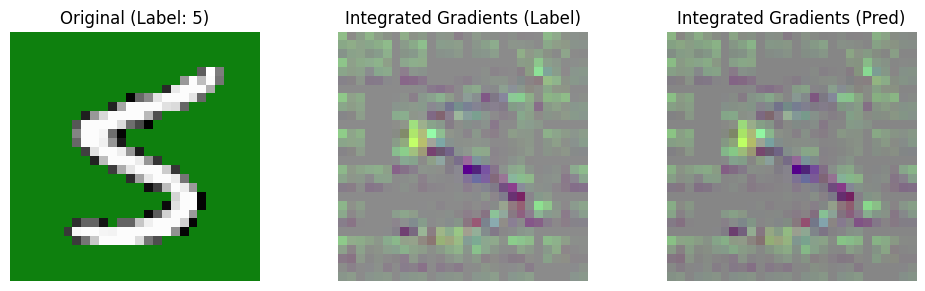

In [107]:
# Normalizar para mostrar
attr_label = (attr_label - attr_label.min()) / (attr_label.max() - attr_label.min())
attr_pred = (attr_pred - attr_pred.min()) / (attr_pred.max() - attr_pred.min())
image = (image - image.min()) / (image.max() - image.min())

# Mostrar imagen original y mapa de importancia
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(to_pil(image.squeeze()))
ax[0].set_title(f"Original (Label: {label})")
ax[1].imshow(to_pil(attr_label.squeeze()))
ax[1].set_title("Integrated Gradients (Label)")
ax[2].imshow(to_pil(attr_pred.squeeze()))
ax[2].set_title("Integrated Gradients (Pred)")
for a in ax: a.axis("off")
plt.tight_layout()
plt.show()


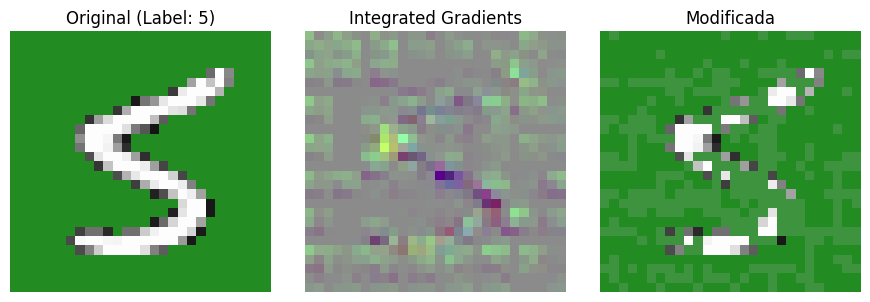

In [25]:
# --- 1️⃣ Calcular relevancia promedio por píxel ---
# attr_ig tiene forma (1, 3, 28, 28)
attr_mean = attr_ig.squeeze().detach().cpu().numpy().mean(axis=0)  # (28, 28)

# --- 2️⃣ Calcular el umbral (35% píxeles menos relevantes) ---
threshold = np.percentile(attr_mean, 35)  # puedes ajustar el 35%

# --- 3️⃣ Crear máscara de píxeles "negativos" ---
mask = attr_mean < threshold  # (28, 28)

# --- 4️⃣ Aplicar la máscara sobre la imagen original ---
img_np = img.squeeze().detach().cpu().numpy()  # (3, 28, 28)
img_mod = img_np.copy()

# Sustituimos los píxeles con baja relevancia por el promedio global (por canal)
for c in range(3):
    channel_mean = img_np[c].mean()
    img_mod[c][mask] = channel_mean

# --- 5️⃣ Visualizar resultado ---
img_mod_pil = to_pil(torch.tensor(img_mod))

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].imshow(to_pil(img.squeeze()))
ax[0].set_title(f"Original (Label: {label})")
ax[1].imshow(to_pil(attr.squeeze()))
ax[1].set_title("Integrated Gradients")
ax[2].imshow(img_mod_pil)
ax[2].set_title("Modificada")
for a in ax: a.axis("off")
plt.tight_layout()
plt.show()

In [26]:
with torch.no_grad():
    pred_orig = model(image).argmax(dim=1).item()
    pred_mod = model(torch.tensor(img_mod).unsqueeze(0).to(device)).argmax(dim=1).item()

print(f"Predicción original: {pred_orig}")
print(f"Predicción modificada: {pred_mod}")

Predicción original: 1
Predicción modificada: 1


#### Saliency Maps

In [51]:
class SaliencyMap:
    """
    This is the class for computing saliency maps.

    Attr:
        model: model used to classify.
    """

    def __init__(self, model: torch.nn.Module) -> None:
        """
        This function is the constructor

        Args:
            model: model used to classify.

        Returns:
            None.
        """

        self.model = model

    def explain(self, inputs: torch.Tensor, target: int) -> torch.Tensor:
        """
        This method computes the explanation.

        Args:
            inputs: inputs tensor. Dimensions: [batch, channels,
                height, width].
            target: target class index.

        Raises:
            RuntimeError: No gradients were computed during the
                backward pass.

        Returns:
            saliency maps tensor. Dimensions: [batch, height, width].
        """
        inputs.requires_grad = True
        outputs = self.model(inputs)
        
        print("Outputs:", outputs)
        # logits, _ = torch.max(outputs, dim=1)
        logits = outputs[:, target]
        print("Logits:", logits)
        torch.sum(logits).backward()
        # if inputs.grad is not None:
        #     return torch.max(torch.abs(inputs.grad), dim=1).values
        if inputs.grad is None:
            raise RuntimeError("No gradients computed during backward pass.")

        # Input x Gradient
        saliency = torch.abs(inputs * inputs.grad)

        # Tomar el máximo a lo largo de los canales (para RGB → 1 mapa)
        saliency, _ = torch.max(saliency, dim=1)
        
        return saliency

Outputs: tensor([[ -8.9227, -26.3946,   7.4754, -16.3876,   0.6705, -16.4831,   0.4768,
         -23.9147,   7.5392, -27.8368]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Logits: tensor([-23.9147], device='cuda:0', grad_fn=<SelectBackward0>)


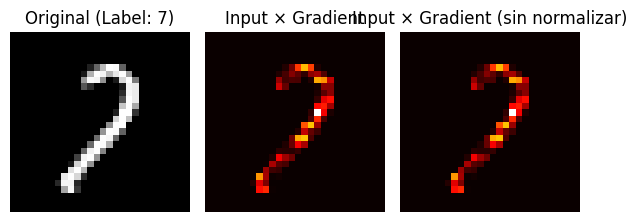

In [118]:
# --- 2️⃣ Cargar una imagen de ejemplo ---
# image = to_tensor(Image.open(image_files[4])).unsqueeze(0).to(device)
image = gray_img.unsqueeze(1).repeat(1, 3, 1, 1).to(device)
# Asegúrate de tener algo como:
#   image.shape == [1, 3, H, W]
# y normalizado igual que en el entrenamiento del modelo.

label = int(image_files[3].stem[-1])  # si lo tienes de esa forma


# --- 3️⃣ Crear el explicador y calcular el mapa ---
explainer = SaliencyMap(model)
saliency = explainer.explain(image.to(device), label)  # [1, H, W]

# Normalizar el mapa para visualización
saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min())


# --- 4️⃣ Visualizar ---
fig, ax = plt.subplots(1, 3, figsize=(6, 3))
ax[0].imshow(to_pil(image.squeeze().cpu()))
ax[0].set_title(f"Original (Label: {label})")
ax[0].axis("off")

ax[1].imshow(saliency_norm.squeeze().detach().cpu(), cmap="hot")
ax[1].set_title("Input × Gradient")
ax[1].axis("off")

# Show saliency without normalization
ax[2].imshow(saliency.squeeze().detach().cpu(), cmap="hot")
ax[2].set_title("Input × Gradient (sin normalizar)")
ax[2].axis("off")

plt.tight_layout()
plt.show()

Label real: 7 | Pred antes: 8 | Pred después: 2


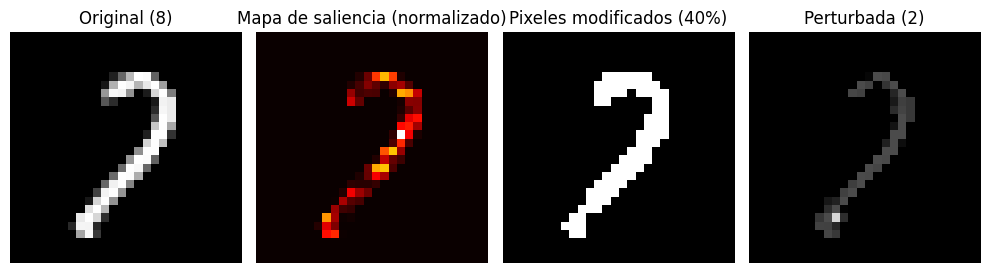

In [119]:
# --- 4️⃣ Seleccionar el 40 % superior de píxeles más relevantes ---
saliency_abs = saliency.abs()
flat = saliency_abs.view(-1)
k = int(0.1 * flat.numel())  # 40%
threshold = torch.topk(flat, k).values.min()
mask = (saliency_abs > threshold).float().unsqueeze(0)  # [1, H, W]

# --- 5️⃣ Alterar los píxeles seleccionados ---
alpha = 0.7  # intensidad del cambio
# Opción: mover en dirección contraria al gradiente (para "corregir" predicción)
perturbed = image - alpha * saliency.sign().unsqueeze(1) * mask.unsqueeze(1)
perturbed = perturbed.clamp(0, 1).squeeze(0)  # [1, C, H, W]

# --- 6️⃣ Evaluar predicciones ---
with torch.no_grad():
    pred_before = model(image).argmax(dim=1).item()
    pred_after = model(perturbed).argmax(dim=1).item()

print(f"Label real: {label} | Pred antes: {pred_before} | Pred después: {pred_after}")

# --- 7️⃣ Visualización ---
fig, ax = plt.subplots(1, 4, figsize=(10, 3))

ax[0].imshow(to_pil(image.squeeze().cpu()))
ax[0].set_title(f"Original ({pred_before})")
ax[0].axis("off")

ax[1].imshow(saliency_norm.squeeze().detach().cpu(), cmap="hot")
ax[1].set_title("Mapa de saliencia (normalizado)")
ax[1].axis("off")

ax[2].imshow(mask.squeeze().cpu(), cmap="gray")
ax[2].set_title("Pixeles modificados (40%)")
ax[2].axis("off")

ax[3].imshow(to_pil(perturbed.squeeze().cpu()))
ax[3].set_title(f"Perturbada ({pred_after})")
ax[3].axis("off")

plt.tight_layout()
plt.show()

c:\Users\Alex MGG\AppData\Local\Programs\Python\Python311\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


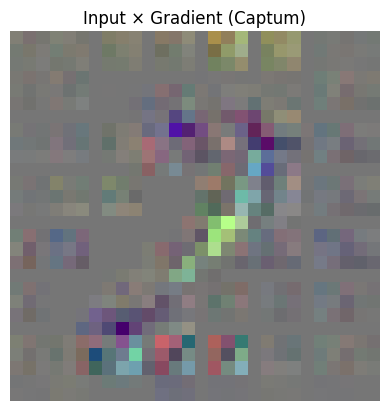

In [37]:
from captum.attr import InputXGradient
import torch
import matplotlib.pyplot as plt

model.eval()

# Cargar imagen [1, C, H, W]
image = to_tensor(Image.open(image_files[3])).unsqueeze(0).to(device)
label = int(image_files[3].stem[-1])

# Crear el método de explicabilidad
ixg = InputXGradient(model)
attr = ixg.attribute(image, target=label)

# Normalizar para visualizar
attr_norm = (attr - attr.min()) / (attr.max() - attr.min())

plt.imshow(attr_norm.squeeze().permute(1, 2, 0).detach().cpu())
plt.title("Input × Gradient (Captum)")
plt.axis("off")
plt.show()


Label real: 7 | Pred antes: 3 | Pred después: 3


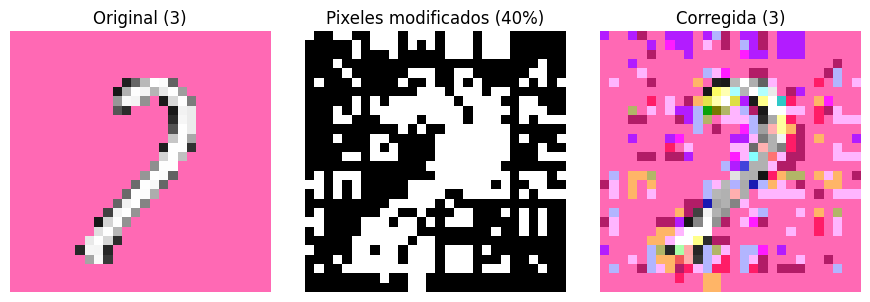

In [38]:
# --- 3️⃣ Seleccionar el 40 % superior ---
saliency = attr.abs().mean(dim=1, keepdim=True)  # [1,1,H,W]
flat = saliency.view(-1)
k = int(0.4 * flat.numel())
threshold = torch.topk(flat, k).values.min()
mask = (saliency >= threshold).float()  # 1 en píxeles a modificar

# --- 4️⃣ Alterar los píxeles seleccionados ---
alpha = 0.3  # intensidad del cambio
# Opción A: mover en dirección opuesta al gradiente (corregir predicción)
image_corrected = image - alpha * attr.sign() * mask
# (Opción B: reforzar la clase correcta -> usa '+ alpha' en vez de '- alpha')
image_corrected = image_corrected.clamp(0, 1)

# --- 5️⃣ Evaluar predicción antes/después ---
with torch.no_grad():
    pred_before = model(image).argmax(dim=1).item()
    pred_after = model(image_corrected).argmax(dim=1).item()

print(f"Label real: {label} | Pred antes: {pred_before} | Pred después: {pred_after}")

# --- 6️⃣ Visualizar ---
img_np = image.squeeze().permute(1,2,0).detach().cpu().numpy()
img_corr = image_corrected.squeeze().permute(1,2,0).detach().cpu().numpy()
mask_np = mask.squeeze().cpu().numpy()

plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title(f"Original ({pred_before})")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask_np, cmap="gray")
plt.title("Pixeles modificados (40%)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_corr)
plt.title(f"Corregida ({pred_after})")
plt.axis("off")

plt.tight_layout()
plt.show()

#### Gradient ascent

In [34]:
image = to_tensor(Image.open(image_files[0])).unsqueeze(0).to(device)
image.requires_grad = True
label = int(image_files[0].stem[-1])

output = model(image)
pred = output.argmax(dim=1).item()

print(f"Pred: {pred}, Label: {label}")

output_label = output[0, label]
output_pred = output[0, pred]

loss = -output_label if label == pred else output_pred - output_label
loss.backward()

grad = image.grad.detach()  # [1, C, H, W]

Pred: 1, Label: 5


c:\Users\Alex MGG\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


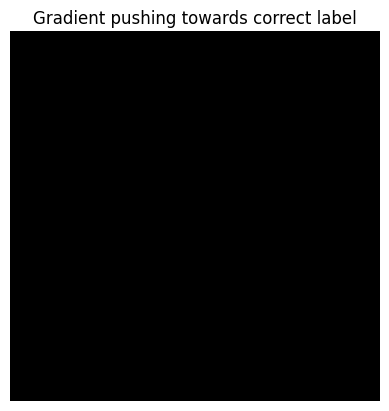

In [35]:
grad_norm = grad / grad.abs().max()
plt.imshow(grad_norm.squeeze().permute(1, 2, 0).cpu(), cmap='bwr', vmin=-1, vmax=1)
plt.title("Gradient pushing towards correct label")
plt.axis("off")
plt.show()

---
## Check if you have passed the challenge 

In [225]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [226]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 0_label5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 37.50%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 37.50%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 37.50%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 37.50%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 37.50%
